In [1]:
%%capture
!pip install wget

In [2]:
from abc import abstractmethod, ABC
import os
import wget
from pathlib import Path

from nltk.tokenize import RegexpTokenizer
import re
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, _BaseNB, _BaseDiscreteNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed()
from typing import Tuple, List, Optional, Union, Dict

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Please add necessary imports here
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
%%capture
filename = wget.download("https://github.com/MIE451-1513-2023/course-datasets/raw/main/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip

In [4]:
## IMPORTANT: DO NOT CHANGE THESE GLOBAL VARIABLES!
DATA_DIR = "20_newsgroups"
ALL_FILES = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [5]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    new_text = re.sub("Lines:.*?\n", "", new_text)
    new_text = re.sub("Reply-To:.*?\n", "", new_text)
    new_text = re.sub("Message-ID:.*?\n", "", new_text)
    new_text = re.sub("From:.*?\n", "", new_text)
    new_text = re.sub("NNTP-Posting-Host:.*?\n", "", new_text)
    return new_text

In [6]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r"\w+")
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [7]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ["talk.politics.mideast", "rec.autos", "comp.sys.mac.hardware", "alt.atheism", "rec.sport.baseball",
     "comp.os.ms-windows.misc", "rec.sport.hockey", "sci.crypt", "sci.med", "talk.politics.misc",
     "rec.motorcycles", "comp.windows.x", "comp.graphics", "comp.sys.ibm.pc.hardware", "sci.electronics",
     "talk.politics.guns", "sci.space", "soc.religion.christian", "misc.forsale", "talk.religion.misc"]
    return topics.index(topic_name)

In [8]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)

    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1: Binary Encoding

### Q1 (a)
The feature sets and labels are constructed as follows. We first find the num_words (a variable number) most common words across all documents. We do this by looping through all documents and adding the count of each word in each document to a Counter object. Then, we assign each document a feature vector and a label. The feature vector is a binary vector (vector of 0s and 1s) that tells us whether or not each of the num_words most common words appeared or not in this particular document. The label is an integer from 0 to n-1, where n is the number of topics. The mapping from index to topic is defined in the topic_list global variable defined above this cell. \
Regarding size of dataset, there are 19997 files and 20 topics.

### Q1 (b)

Complete the *train_and_predict* method of the *Classifier* class.

In [9]:
class Classifier(ABC):
    """
    Defines the super class that all classifier classes have to inherit.
    This class requires one argument 'model_cls' which should be the sklearn classfication algorithm class.
    For example, 'LogisticRegression' or 'MultinomialNB' can be used.
    """
    _X, _y = None, None      # Class variables that store features and labels

    def __init__(self, model_cls):
        self._model_cls = model_cls

    @abstractmethod
    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This is an abstract method which has to be implemented in subclasses.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        pass

    # DO NOT ADD TO OR MODIFY THE ARGUMENTS AND THE KEYWORD ARGUMENTS TO THIS METHOD!!
    def train_and_predict(
            self, file_list=None, X=None, y=None, test_size=0.3, random_state=22, **model_kwargs
    ) -> Tuple[Dict, Dict]:
        """
        Complete this method for Q1(b).

        This method (1) constructs the dataset; (2) splits it into train/test sets;
        (3) trains a multi-class classifier model with the type 'self._model_cls';
        (4) evaluates the trained model with the test set;
        (5) and finally returns the dataset and accuracy information as dictionaries.

        """
        # This method can also be used with an already-built dataset (X, y)
        if file_list is None:
            assert X is not None and y is not None, "Either 'file_list' or (X, y) should be provided"

        # Get the dataset (features and labels) if not provided
        if X is None or y is None:
            X, y = self.get_dataset(file_list)

        ####### TODO: Q1(b) #######
        # Split the dataset to train and test sets.
        # Hint:
        #   Make a proper call to the 'train_test_split' function with 'test_size'
        #   and 'random_state' passed as arguments. Store the resulting sets into
        #   'X_train', 'X_test', 'y_train', 'y_test'.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        ####################

        ####### TODO: Q1(b) #######
        # Train a classifier of type 'self._model_cls' using the train set.
        # Hint:
        #   Use 'self._model_cls' while 'model_kwargs' should be passed to
        #   its constructor as keyword arguments.  Call the 'fit' function of
        #   the classifier with the right pair of (feature, label) to train the model.
        #   Store the resulting classifier to 'clf'.
        clf = self._model_cls(**model_kwargs)
        clf.fit(X_train, y_train)

        ####################

        # Make predictions with the train and test sets
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        ####### TODO: Q1(b) #######
        # Calculate the train and test accuracy
        # Hint:
        #   Use the 'accuracy_score' function and save the respective accuracy to
        #   'train_accuracy' and 'test_accuracy'.
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        ####################

        # Values to return
        dataset = dict(
            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
        )
        info = dict(
            y_train_predict=y_train_predict, y_test_predict=y_test_predict,
            train_accuracy=train_accuracy, test_accuracy=test_accuracy
        )

        # Validate return types
        assert isinstance(train_accuracy, float) and isinstance(test_accuracy, float), "incorrect return types"
        assert isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame), "incorrect return types"
        assert isinstance(y_train, list) and isinstance(y_test, list), "incorrect return types"
        assert isinstance(y_train_predict, np.ndarray) and isinstance(y_test_predict, np.ndarray), "incorrect return types"

        return dataset, info

    @staticmethod
    def get_performance_ci(
            classifier, X=None, y=None, num_tests=10, test_size=0.3, file_list=None
    ) -> Tuple[float, float, float, float, float, float]:
        if X is None or y is None:
            assert file_list is not None, "When X/y is not passed, you should provide 'file_list'"
            X, y = classifier.get_dataset(file_list)

        # 'train_results' is a list of train accuracy for differrent random splits of the dataset
        train_results = []

        # 'test_results' is a list of test accuracy for differrent random splits of the dataset
        test_results = []

        ####### TODO: Q1(e) #######
        # Write your code here for Q1(e).
        # Hint:
        #   First, randomly generate a set of integers to be used as random states using,
        #   e.g., 'np.random.randint', 'random.randint', or even np.random.permutation
        #   (these functions act differently, so beware of it).
        #   Then, you should call the 'classifier.train_and_predict' method by passing
        #   the random state, the dataset, and the test_size to get the accuracy results.
        #   Notice that you should be able to retrieve the accuracy info from
        #   the returned 'info' dictionary. Finally, make sure to retrieve and append
        #   the train and test accuracy results to the corresponding lists defined above.
        rand_states = np.random.permutation(range(1000))[:num_tests]
        for rand_state in rand_states:
          dataset, info = classifier.train_and_predict(X=X, y=y, test_size=test_size, random_state=rand_state)
          train_results.append(info["train_accuracy"])
          test_results.append(info["test_accuracy"])

        ####################

        # Calculate the train mean and the 95% confidence interval for the list of results
        train_mean = np.mean(train_results)
        train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))

        # Calculate the test mean and the 95% confidence interval for the list of results
        test_mean = np.mean(test_results)
        test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))

        # Validate return types
        assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
        assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"

        return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

    @staticmethod
    def create_cm(
            classifier, X: pd.DataFrame, y: List[int], num_tests: int, test_size=0.3
    ) -> np.ndarray:
        # 'cm_list' should contain the confusion matrices for different random splits of the dataset
        cm_list = []

        ####### TODO: Q1(g) #######
        # Write your code here for Q1(g).
        # Hint:
        #   Again, you should generate 'random_state's and pass them to the
        #   'classifier.train_and_predict' method along with the dataset ('X' and 'y').
        #   Observe that you can get the true labels and the predictions
        #   from the returned dictionaries of the method.
        #   Make proper calls to the 'confusion_matrix' function and store the
        #   results to 'cm_list'.
        rand_states = np.random.permutation(range(1000))[:num_tests]
        for rand_state in rand_states:
          dataset, info = classifier.train_and_predict(X=X, y=y, test_size=test_size, random_state=rand_state)
          y_test, y_test_predict = dataset['y_test'], info['y_test_predict']
          cm_list.append(confusion_matrix(y_test, y_test_predict))
        ####################

        # Sum the confusion matrices and return the combined confusion matrix
        combined_cm = np.array(cm_list).sum(axis=0)

        # validate return type
        assert isinstance(combined_cm, np.ndarray), "return type"

        return combined_cm

    @property
    @abstractmethod
    def X(self):
        pass

    @property
    @abstractmethod
    def y(self):
        pass

    @X.setter
    @abstractmethod
    def X(self, X):
        pass

    @y.setter
    @abstractmethod
    def y(self, y):
        pass

In [10]:
class ClassifierWithBinaryEncoding(Classifier):

    _X, _y = None, None

    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the binary encoding for features, where the most common
        'num_words' number of terms are used.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        # Calculate word count in corpus
        news_cnt = corpus_count_words(file_list)

        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

        # Create a binary encoding of dataset based on the selected features (X)
        tokenizer = RegexpTokenizer(r"\w+")
        df_rows = []
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                df_rows.append([1 if word in file_words else 0 for word in word_list])
        X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns=word_list)

        # Create a dataframe of targets (y)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        self.X = X; self.y = y

        return X, y

    @property
    def X(self):
        return ClassifierWithBinaryEncoding._X

    @property
    def y(self):
        return ClassifierWithBinaryEncoding._y

    @X.setter
    def X(self, X):
        ClassifierWithBinaryEncoding._X = X

    @y.setter
    def y(self, y):
        ClassifierWithBinaryEncoding._y = y

### Q1 (b) (cont.)

Use the following code to compute the train/test accuracy of the baseline model.  Note that you should have correctly implemented the *train_and_predict* method in the *Classifier* class in order to proceed without an error.

In [11]:
# Instantiate the classifier
q1_b = ClassifierWithBinaryEncoding(model_cls=LogisticRegression)

# Construct the dataset and train the classifier
X_base, y = q1_b.get_dataset(file_list=ALL_FILES)
q1_b_dataset, q1_b_info = q1_b.train_and_predict(
    X=X_base, y=y, test_size=0.3, random_state=22, C=1.0)

In [12]:
train_accuracy_q1b = q1_b_info['train_accuracy']
test_accuracy_q1b = q1_b_info['test_accuracy']

# report results
print(f"Train accuracy of the baseline model: {train_accuracy_q1b}")
print(f"Test accuracy of the baseline model: {test_accuracy_q1b}")

Train accuracy of the baseline model: 0.947488747588769
Test accuracy of the baseline model: 0.6786666666666666


### Q1 (c)

Implement an improved feature set in the *get_dataset* method of the following class.

In [13]:
def corpus_count_words_1c(file_list):
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r"\w+")
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            file_data = file.read()
            file_data = clean_file_text(file_data).lower()
            file_words = tokenizer.tokenize(file_data)
            file_words = [word for word in file_words if word not in stop_words]
            word_counter.update(file_words)
    return word_counter

In [14]:
class ClassifierWithImprovedBinaryEncoding(ClassifierWithBinaryEncoding):

    _X = None

    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the binary encoding for features, where the most common
        'num_words' number of terms are used. Further, this class should use
        improved features than the one given by its super class.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X = None
        y = self.y      # Could be None if 'ClassifierWithBinaryEncoding.get_dataset()' has not been called

        ####### TODO: Q1(c) #######
        # Make improvements to the feature set by using any techniques covered in the IR lab.
        # Note that you should still use the binary encoding, not term frequencies.
        #
        # Hint:
        #   Please remember to put index for your dataframe as the file name;
        #   columns should match with the terms used as features.
        #   For example: pd.DataFrame(data, index=[str(f) for f in file_list], columns=[...])
        news_cnt = corpus_count_words_1c(file_list)

        top_words = [word for (word, freq) in news_cnt.most_common(num_words)]

        tokenizer = RegexpTokenizer(r'\w+')
        df_rows = []
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                stage1 = tokenizer.tokenize(file_data.lower())
                stop_words = set(stopwords.words('english'))
                stage2 = [token for token in stage1 if token not in stop_words]
                file_words = set(stage2)
                df_rows.append([1 if word in file_words else 0 for word in top_words])
        X = pd.DataFrame(df_rows, columns = top_words)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]
        ####################
        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y

        return X, y

    @property
    def X(self):
        return ClassifierWithImprovedBinaryEncoding._X

    @X.setter
    def X(self, X):
        ClassifierWithImprovedBinaryEncoding._X = X


### Q1 (d)

Use the following code to compute the train/test accuracy of the model with improved features.  Note that you should have correctly implemented the *train_and_predict* method in the *Classifier* class in order to proceed without an error.

In [15]:
# Instantiate the classifier
q1_c = ClassifierWithImprovedBinaryEncoding(LogisticRegression)

# Construct the dataset and train the classifier
X_b_improved, y = q1_c.get_dataset(ALL_FILES, num_words=1000)
q1_c_dataset, q1_c_info = q1_c.train_and_predict(
    X=X_b_improved, y=y, test_size=0.3, random_state=22, C=1.0)

In [16]:
# Retrieve and report the results
train_accuracy_q1c = q1_c_info['train_accuracy']
test_accuracy_q1c = q1_c_info['test_accuracy']

print(f"Train accuracy of the improved model: {train_accuracy_q1c}")
print(f"Test accuracy of the improved model: {test_accuracy_q1c}")

Train accuracy of the improved model: 0.9539901407444452
Test accuracy of the improved model: 0.7206666666666667


The train acc went up from 0.947488747588769 to 0.9539901407444452. The test acc went up from 0.6786666666666666 to 0.7206666666666667.

### Q1 (e)

Implement and complete the *get_performance_ci* method of the *Classifier* class above.

### Q1 (f)

Use the following code to compute the mean accuracy and 95% confidence interval over 10 random splits.

In [17]:
train_mean_bin, train_low_bin, train_high_bin, test_mean_bin, test_low_bin, test_high_bin = Classifier.get_performance_ci(q1_c, X_b_improved, y, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_bin}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_bin}, {train_high_bin}]")
print(f"Average test accuracy over 10 random splits: {test_mean_bin}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_bin}, {test_high_bin}]")

Average training accuracy over 10 random splits: 0.9539329856397799
Confidence interval for training accuracy over 10 random splits: [0.9528680543018927, 0.9549979169776671]
Average test accuracy over 10 random splits: 0.7220333333333333
Confidence interval for test accuracy over 10 random splits: [0.7174746585702795, 0.7265920080963871]


The average and 95% confidence interval give a better picture of the consistency of the model. The average accuracy over several trials is better than one trial as it reduces impact of outliers in results. The confidence interval gives an idea of how consistent that average is. Ideally, when keeping the same split ratio but modifying the random state, we should see the accuracy deviate only by a little, caused by the random seed and thus avoid any overfitting.

### Q1 (g)

Implement and complete the *create_cm* method of *Classifier* class above.

### Q1 (h):

Use the following code to produce a confusion matrix for 10 random splits.

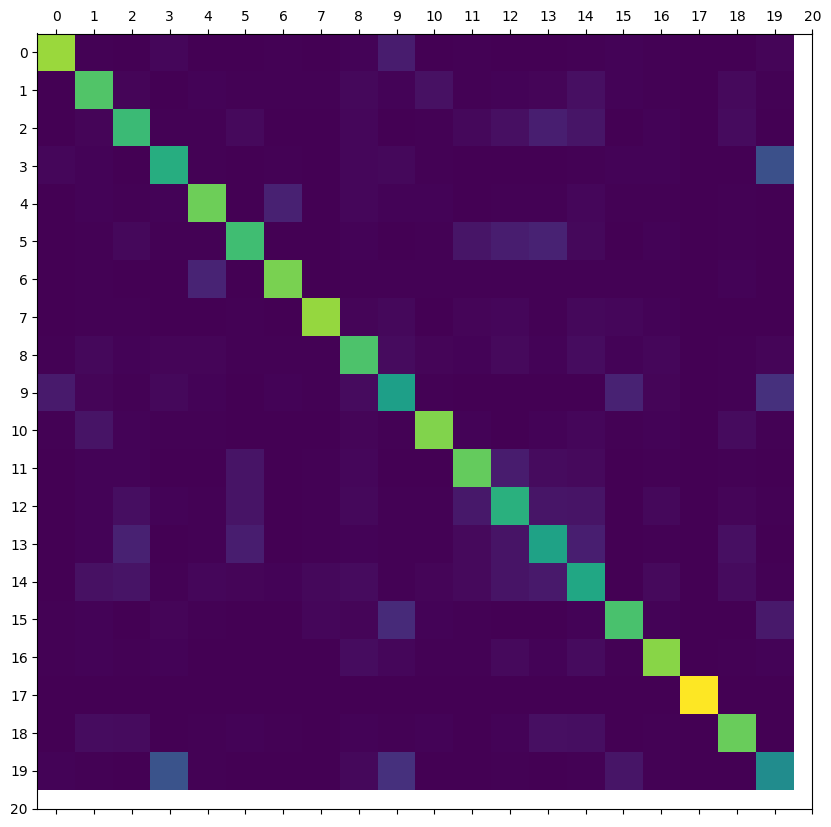

In [18]:
cm10 = Classifier.create_cm(q1_c, X_b_improved, y, num_tests=10, test_size=0.3)
plot_confusion_matrix(cm10)

topic 3 (alt.atheism) and topic 19 (talk.religion.misc) are easily confused. So are topic 9 (talk.politics.misc) and topic 19. Topics 3 and 19 both have a religious context/background, and topics 9 and 19 both focus on miscellaneous subjects. Thus, it makes sense these pairs of topics are easily confused with each other, because they are similar in nature.

## Q2: Number of Features

### Q2 (a)

Implement the method *predict_with_varying_num_features* below.

In [19]:
class ClassifierWithVaryingNumFeatures(ClassifierWithImprovedBinaryEncoding):
    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def predict_with_varying_num_features(
            self,
            X: pd.DataFrame,
            y: List[int],
            p_lst: List[float],  # list of percentages of features to use
            test_size=0.3,
            random_state=22
    ) -> pd.DataFrame:
        # 'result_list' is a list of tuples (num_features, train_accuracy, test_accuracy)
        # where 'num_features' is the number of words used as features
        result_list = []

        # Note: only use a single train/test split for this evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        for p in p_lst:
            subset_size = int(p*X.shape[1])
            X_train_subset = X_train.iloc[:, 0:subset_size]
            X_test_subset = X_test.iloc[:, 0:subset_size]

            clf = self._model_cls()
            clf.fit(X_train_subset, y_train)
            y_train_predict = clf.predict(X_train_subset)
            y_test_predict = clf.predict(X_test_subset)

            train_accuracy = accuracy_score(y_train, y_train_predict)
            test_accuracy = accuracy_score(y_test, y_test_predict)

            # Add to 'result_list'
            result_list.append((p, train_accuracy, test_accuracy))

        # Make a dataframe of the results
        result_df = pd.DataFrame(result_list,
                                 columns=["num_features", "train_accuracy", "test_accuracy"])

        # Validate return type
        assert isinstance(result_df, pd.DataFrame), "return type"

        return result_df


### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature set sizes

<Axes: xlabel='num_features'>

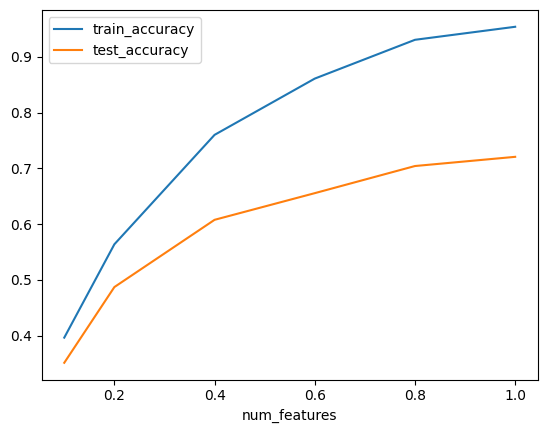

In [20]:
q2 = ClassifierWithVaryingNumFeatures(LogisticRegression)
p_lst = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
feature_num_df = q2.predict_with_varying_num_features(X_b_improved, y, p_lst)

feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

Observation: Initially, increasing the number of features leads to large gains in both train and test accuracy. however, as we continue to increase the number of features, the incremental gains become smaller, as the additional words we consider are not as important as the first few words. After p=0.8, we are essentially stabilized.

## Q3: Hyperparameter Tuning

### Q3 (a)

Complete the _hyperparameter_ function below.

In [21]:
def hyperparameter(
    classifier: Classifier,
    X: pd.DataFrame,
    y: List[int],
    param_list: List[float],
    test_size: float = 0.3,
    random_state: int = 22,
) -> pd.DataFrame:
    # 'result_list' is a list of tuples (param, train_accuracy, test_accuracy)
    # where 'param' is the hyperparameter value used for training.
    result_list = []

    # Note that this function uses a single train/test split
    # If the trends are not clear, try repeating this for multiple random splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    for param in param_list:
        ####### TODO: Q3(a) #######
        # Write your code here to calculate 'train_accuracy' and 'test_accuracy'
        # for the current hyperparameter value 'param'.
        #
        # Hint:
        #   You can simply use the 'train_and_predict' method of the 'classifier' object.
        #   Just figure out how to pass the hyperparameter value correctly to
        #   the method such that the classifier uses the hyperparameter.
        _, info = classifier.train_and_predict(X=X, y=y, test_size=test_size, random_state=random_state, C=param)
        ####################
        train_accuracy = info['train_accuracy']
        test_accuracy = info['test_accuracy']

        # Add to result_list
        result_list.append((param, train_accuracy, test_accuracy))

    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])

    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"

    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy from different hyperparameters.



In [22]:
param_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_df = hyperparameter(
    classifier=q1_c,
    X=X_b_improved,
    y=y,
    param_list=param_list,
    test_size=0.3,
    random_state=22,
)

<Axes: xlabel='param'>

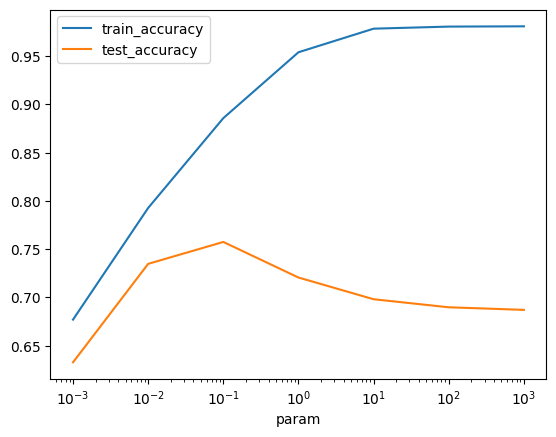

In [23]:
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

Initially, as C increases, both the train and test accuracies increase. However, after the seemingly optimal value of approximately C=0.1, the train accuracy increases but the test accuracy decreases. This is due to the higher value of C resulting in a lower regularization term, which allows for classic overfitting problem in ML. The model begins to overfit to the train dataset and cannot generalize to the test set.

## Q4: Feature Encoding (Term Frequency)

### Q4 (a)

Implement the *get_dataset* method of the _ClassifierWithTFEncoding_ class.

In [24]:
class ClassifierWithTFEncoding(ClassifierWithBinaryEncoding):

    _X = None

    def __init__(self, model_cls):
        super().__init__(model_cls=model_cls)

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Put your code for Q4(a) here.

        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the term frequency encoding for features, where the most
        common 'num_words' number of terms are used. Further, this class should
        use the improved features from Q1(c) rather than the baseline we provided.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X, y = None, None

        ####### TODO: Q4(a) #######
        # Use the term frequencies to construct the feature set.
        # You should only use 'num_words' number of terms as features,
        # which you should obtain by using any techniques covered in the IR lab (as in Q1(b)).
        #
        # Hint:
        #   Please remember to put index for your dataframe as the file name;
        #   columns should match with the terms used as features.
        #   For example: pd.DataFrame(data, index=[str(f) for f in file_list], columns=[...])
        news_cnt = corpus_count_words_1c(file_list)

        top_words = [word for (word, freq) in news_cnt.most_common(num_words)]

        tokenizer = RegexpTokenizer(r'\w+')
        df_rows = []
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                stage1 = tokenizer.tokenize(file_data.lower())
                stop_words = set(stopwords.words('english'))
                stage3 = [token for token in stage1 if token not in stop_words]
                word_freqs = dict(Counter(stage3))
                df_rows.append([word_freqs[word] if word in word_freqs else 0 for word in top_words])
        X = pd.DataFrame(df_rows, columns = top_words)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]
        ####################

        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y
        return X, y

    @property
    def X(self):
        return ClassifierWithTFEncoding._X

    @X.setter
    def X(self, X):
        ClassifierWithTFEncoding._X = X

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [25]:
q4 = ClassifierWithTFEncoding(LogisticRegression)
X_tf, y_tf = q4.get_dataset(ALL_FILES)

In [26]:
train_mean_tf, train_low_tf, train_high_tf, test_mean_tf, test_low_tf, test_high_tf = Classifier.get_performance_ci(q4, X_tf, y_tf, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_tf}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_tf}, {train_high_tf}]")
print(f"Average test accuracy over 10 random splits: {test_mean_tf}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_tf}, {test_high_tf}]")

Average training accuracy over 10 random splits: 0.9353147102950631
Confidence interval for training accuracy over 10 random splits: [0.9309176374983824, 0.9397117830917437]
Average test accuracy over 10 random splits: 0.7186166666666667
Confidence interval for test accuracy over 10 random splits: [0.7161979131128876, 0.7210354202204458]


Average test accuracy for binary vs TF is 0.722 vs 0.7217666666666667. The confidence interval for binary vs TF is [0.7180055779438753, 0.7259944220561246] vs [0.7188672941075722, 0.7246660392257611]. Overall, the first method performs better, but by a very small margin. I think this occurs because the classfication is probably successful due to a few "give-away" words for each topic; so either way, with binary of TF, a value of 0 means the word is not present. TF is sensitive to exactly how many times those words appear, but binary just cares if it is there, which may in fact work better if these words are really obvious terms for the topic.

## Q5: Comparison vs. Naive Bayes

### Q5 (a)

Implement a naive Bayes classifier

In [27]:
def evaluate_nb(X, y, num_tests) -> Tuple[Classifier, Tuple]:
    train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high = [None] * 6
    # nb_classifier: Classifier = None

    ####### TODO: Q5(a) #######
    # Instantiate a Naive Bayes classifier and compute the train/test accuracies.
    # You should return the mean and the confidence bound of the train and test accuracies.
    #
    # Hint:
    #   Note that you can specify the classification algorithm when instantiating
    #   a Classifier object. Then, you can use the 'get_performance_ci' method.
    nb_classifier = ClassifierWithImprovedBinaryEncoding(MultinomialNB)
    train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high = nb_classifier.get_performance_ci(nb_classifier, X=X, y=y, num_tests=num_tests)
    ####################

    # Validate return types
    assert isinstance(nb_classifier, Classifier)and 'NB' in nb_classifier._model_cls.__name__, "incorrect return types"
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "incorrect return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "incorrect return types"

    return nb_classifier, (train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high)

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits.

In [28]:
nb_classifier, (train_mean_nb, train_low_nb, train_high_nb, test_mean_nb, test_low_nb, test_high_nb) = evaluate_nb(X_b_improved, y, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_nb}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_nb}, {train_high_nb}]")
print(f"Average test accuracy over 10 random splits: {test_mean_nb}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_nb}, {test_high_nb}]")

Average training accuracy over 10 random splits: 0.7736586411373866
Confidence interval for training accuracy over 10 random splits: [0.7714208333534508, 0.7758964489213224]
Average test accuracy over 10 random splits: 0.7147166666666667
Confidence interval for test accuracy over 10 random splits: [0.7110046442815445, 0.7184286890517888]


Average train accuracy for Logistic Regression vs Naive Bayes is 0.722 vs 0.716. 95% confidence interval for Logistic Regression vs Naive Bayes is [0.7180055779438753, 0.7259944220561246] vs [0.7119598052181031, 0.7196068614485633]. So, consistency-wise, they are about the same since the ranges of the confidence intervals are about the same. however, logistic regression is better. This could be because logistic regression models p(y|x) while NB requires p(x|y). NB also assumes the words are independent of each other, so the model itself is definitely not right for text classification.

## Q6: Binary Logistic Regression

### Q6 (a)

Implement the *get_dataset* method of the *BinaryLogisticClassifier* class below.

In [29]:
class BinaryLogisticClassifier(ClassifierWithImprovedBinaryEncoding):

    _y = None

    def __init__(self, model_cls):
        super().__init__(model_cls=model_cls)

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Put your code for Q6(a) here.

        Returns the tuple (X, y) where X is the feature set and y is the label.
        Use the improved binary encoding from Q1(c) for features, where the most
        common 'num_words' number of terms are used.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X, y = None, None

        ####### TODO: Q6(a) #######
        # Put your code below
        # Target values should be 1 for sci.med and 0 for any other labels.
        # Note:
        #   Please remember to put index for your dataframe as the file name;
        #   columns should match with the terms used as features.
        #   For example: pd.DataFrame(data, index=[str(f) for f in file_list], columns=[...])
        X = self._X
        y = [1 if get_topic_name(file_path)=="sci.med" else 0 for file_path in file_list]
        ####################

        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y
        return X, y

    @property
    def y(self):
        return BinaryLogisticClassifier._y

    @y.setter
    def y(self, y):
        BinaryLogisticClassifier._y = y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits.

In [30]:
q6 = BinaryLogisticClassifier(LogisticRegression)
X_bin, y_bin = q6.get_dataset(ALL_FILES, num_words=1000)

In [31]:
train_mean_bin, train_low_bin, train_high_bin, test_mean_bin, test_low_bin, test_high_bin = Classifier.get_performance_ci(q6, X_bin, y_bin, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_bin}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_bin}, {train_high_bin}]")
print(f"Average test accuracy over 10 random splits: {test_mean_bin}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_bin}, {test_high_bin}]")


Average training accuracy over 10 random splits: 0.9884046581410303
Confidence interval for training accuracy over 10 random splits: [0.9879978945457424, 0.9888114217363182]
Average test accuracy over 10 random splits: 0.9722999999999999
Confidence interval for test accuracy over 10 random splits: [0.9711040349841236, 0.9734959650158763]


Both train and test accuracy are close to 1. This shows that logistic regression is very good for binary classification tasks, and the performance degradation we observe previously is due to more classes being added.